# Genetic algorithms

This exercise aims at helping you understand the basic components that make up a genetic algorithm (GA). A general GA has 3 basic operations, that is: selection, crossover, mutation. In this exercise you will go through all of these operation and implement them. You will also encounter a very common issue in optimization which is selecting a proper fitness function that will smoothly guide your search algorithm to a solution.

Before proceeding with the exercise take a look at the following [tutorial](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35) and the corresponding [code](https://github.com/ezstoltz/genetic-algorithm).

We now want you to solve a similar problem for a mobile robot navigation scenario. Imagine that you have a 2D map of free blocks or obstacles. Your robot has a starting and a goal position and needs to learn the optimal route to get there. The problem is depicted in the image below: 

![title](map.png)

For this task you can use a GA whose individuals would represent a series of movements in the map. Each gene is a simple movement primitive in on direction (i.e., North, West, South, East). You can draw inspiration from the tutorial you just read and even use whole blocks of code to solve the problem at hand.

It is recommended that you follow the following instructions to solve the exercise, but if you feel that this is too constrained you may alter the structure completely.

Steps for solving the exercise:

    1. Familiarize yourself with GAs and study the use of the selection, crossover and mutation operations.
    
    2. Implement the MapNode class to hold information concerning a node of the grid. This would include coordinates and the obstacle flag.
    
    3. The code to recreate the map of the above image is already provided.
    
    4. Implement each missing component (selection, crossover, mutation) at a time by commenting the rest. The problem is simple enough for you to manually test if your implementation is correct.
    
    5. Once you feel confident that your basic GA structure is working you will need to construct a good fitness function. **No** there is no perfect fitness function for this problem. You will need to try and fail in order to find one that works. You will also need to implement an appropriate crossover or mutation to guide the search.
    
    6. Allow your GA to run for lots of generations (~ 2000). Although it might seem simple and low dimensional, evolving the optimal solution is not trivial.

    7. Once you are confident that your GA is working, use the plot function that is already provided (and update its generation, population, etc parameters) to visualize the evolution of the fitness over generations. Remember that GAs work in a stochastic manner. This means that you should run your GA at least a few times (say 5) and keep the fitness vs generation plot before you can draw conclusions about the performance of the algorithm and the difficulty of the task you have.
    
    
    
**If you want to write your own GA or do not want to represent the map nodes the way it is proposed, you may re-write everything.**


The optimal solution for this problem is depicted below and corresponds to the following series of movements: 

**EAST - SOUTH - SOUTH - EAST - EAST - EAST - EAST - NORTH - EAST (a total of 9 moves)**


![title](map_solved.png)



# Some python tips

## Classes

You may already be familiar with object-oriented programming. If not do not worry, the exercise is not about that. In python you define a class as follows:

```python

class Foo:
    def __init__(self, someParam): 
        """
        This is the constructor of the class. Never forget the self parameter. 
        It could be loosely seen as the "this" of C++/Java
        """
        self.someParam = someParam # you can store member variables using the self keyword
        
    def fooFun1(self):
        pass
      
    def fooFun2(self, someOtherParam):
        pass
    
    def getSomeParam(self):
        return self.someParam # this is the member variable initialized in the constructor
    
# Using an instance of the class is similar to any other object-oriented language
instance = Foo()
instance.fooFun1()
instance.fooFun2(2)

# accessing member variables of an object
print(instance.getSomeParam())

```

You can find a complete tutorial on classes in the following [link](https://docs.python.org/3/tutorial/classes.html).


## Enums

Enums are generic enumeration data structures that allow you to write more generalized code. In the following template we use Enums to encode the movement primitives. **Once again, if you are not comfortable with the use of Enums feel free to represent the movements in your own way**

```python

from enum import Enum

class Ops(Enum):
        NORTH = 1
        EAST = 2
        SOUTH = 3
        WEST = 4

movements = Ops()

# you can also use the shorthand declartion        
movements = Enum('Οps', 'NORTH EAST SOUTH WEST')  
```


You can find a more complete Enum tutorial for python [here](http://www.blog.pythonlibrary.org/2018/03/20/python-3-an-intro-to-enumerations/).


In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from enum import Enum
from pprint import pprint

## The MapNode class

Create class to handle "MapNode" to represent nodes in the map. Each of those nodes is defined by a set of coordinates and a flag that marks it as an obstacle or not.

You may also define the \__repr\__ function to print the node in graphical way. 

**Note that instead of having a class to represent a node you may use a matrix (numpy array) to represent the whole map. This means you will need to alter the template below.**

In [2]:
class MapNode:
    def __init__(self, x, y, is_obstacle=False):
        """
        :param x: int
        :param y: int 
        :param is_obstacle: bool, optional     
        """
        self.x = x
        self.y = y
        self.is_obstacle = is_obstacle

        
    def setObstacle(self, is_obstacle):
        """
        :brief: Set the node to obstacle (True or False)

        :param is_obstacle: bool
        """
        self.is_obstacle = is_obstacle

        
    def isObstacle(self):
        """
        :brief: Check if the node is an obstacle

        :return: bool
        """
        return self.is_obstacle

    
    def __repr__(self):
        """
        :brief: This is called when the class is printed as is

        :return: str
        """
        if self.is_obstacle:
            return "x"
        else:
            return " "

## Global definitions of variables (Those are used in many functions later)

Setting the dimensions of the map that the robot will explore.

In [3]:
dimX = 7 # dimension of the X axis
dimY = 8 # dimension of the Y axis

Set the possible robot movements and an upper threshold for the trajectory length.

In [4]:
movements = Enum('Οps', 'NORTH EAST SOUTH WEST')     # define the possible robot movements
maxLen = 5 * dimX                                    # define a maximum trajectory length

Create a map with obstacles that the robot will need to navigate. Here each coordinate of the grid map is represented by a MapNode instance stored in a list. 

**This is a design choice you are not obliged to make**. If you think of a better design do not hesitate to change the structure of the code to fit your own logic.

In [5]:
occupancyList = []

# attribute coordinates to each of the map nodes
for row in range(dimY):
    for col in range(dimX):
        occupancyList.append(MapNode(x=row, y=col, is_obstacle=True))

In the previous step we set all the nodes to be obstacles. Below we will free up some of the nodes so that the robot can navigate from the starting positions to the final one.

In [6]:
# set some nodes to not be obstacles
start = (1, 0)
end = (2, 6)

free = [start, end,
        (1, 1), (2, 1), (3, 1), (3, 2),
        (3, 3), (3, 4), (3, 5), (2, 5),
        (4, 1), (4, 2), (4, 4), (4, 5),
        (5, 1), (5, 2), (5, 3), (5, 4), (5, 5),
        (6, 1), (6, 2), (6, 3), (6, 4), (6, 5),
        (1, 5), (1, 4), (1, 3), (2, 3)]

for node in free:
    occupancyList[dimX * node[0] + node[1]].setObstacle(False)

Assuming you have implemented the \__repr\__ function in MapNode the following code snippet will print out the map you defined.

In [7]:
# printing out the initial map
for row in range(dimY):
    for col in range(dimX):
        print(occupancyList[dimX * row + col], end='')
    print('\n', end='')

xxxxxxx
  x   x
x x x  
x     x
x  x  x
x     x
x     x
xxxxxxx


## Create necessary classes and functions

Create a fitness function that will consist of 3 elements given a generated trajectory: 
    1. the distance from the end goal when the trajectory has been traversed
    2. the length of the trajectory (we want reward the shortest path)
    3. the number of collisions with obstacles
    
The above elements should be minimized. **Be careful** that the algorithm in the tutorial is maximizing. You should either adjust your fitness function or the ranking logic.

It is **required** that you experiment with different weights for these 3 elements until you get a good convergence to generation ratio.

In [8]:
class Fitness:
    def __init__(self, route):
        """
        :param route: list of Ops enums
        """
        self.route = route
        self.fitness = None

    def routeCost(self):
        """
        :brief: This function computes the fitness values that
                should be attributed to a route. It needs to 
                take into account:
                1) the collisions with obstacles,
                2) the distance to the goal and 
                3) the length of the generated series of movements (trajectory)
                
        :return: float
        """
        reached = start
        for movement in self.route:
            """
            The code below is similar (but definitely not the same) to 
            a switch - case in other languages. In practice we use 
            the dict structure to select the movement that should be performed.
            """
            reached = {
                movements.NORTH: (reached[0] - 1, reached[1]),
                movements.EAST: (reached[0], reached[1] + 1),
                movements.SOUTH: (reached[0] + 1, reached[1]),
                movements.WEST: (reached[0], reached[1] - 1),
            }[movement]

            """
            If the robot moves outside the map or collides with an obstacle
            we completely disregard the solution by setting a fitness of 0.
            However, this might not help to achieve fast convergence depending
            on your problem. An alternative would be to count the collisions
            and include some kind of penalty in your linear combination of 
            objectives.
            """
            if (reached[0] < 0 
                or reached[1] < 0
                or dimX * reached[0] + reached[1] >= len(occupancyList)
                or occupancyList[dimX * reached[0] + reached[1]].isObstacle()):
                return 0
            
        manhattan_distance = abs(reached[0] - end[0]) + abs(reached[1] - end[1])
        route_length = len(self.route)
        
        """
        The weights are set manually and are not necessarily optimal. Here we 
        assumed that the most important objective is to reach the goal.
        """
        return 1 / (0.10 * route_length
                  + 0.90 * manhattan_distance)

    def routeFitness(self):
        """
        :brief: Fitness value getter

        :return: float
        """
        self.fitness = self.routeCost()
        return self.fitness


## Create our initial population

Here you should implement a function to generate random trajectories that will be attributed a fitness value later on. These routes should have random length up to a maximum value. This will allow for more diverse candidate solutions and possibly alternate valid trajectories.

In [9]:
def createRoute(movements):
    """
    :brief: Creates a randomly generated trajectory of variable length

    :param movements: Ops enum (contains the series of available movements: NORTH - WEST - SOUTH - EAST) 
    :return: list of Ops enums
    """
    route = []
    for _ in range(random.randint(1, maxLen)):
        route.append(random.choice(list(movements)))
    return route

Create first "population" (list of routes).

In [10]:
def initialPopulation(popSize, movements):
    """
    :brief: Initializes the population at the 0th generation of the GA

    :param popSize: int (population size)
    :param movements: Ops enum (contains the series of available movements: NORTH - WEST - SOUTH - EAST)
    :return: list of lists of Ops enums
    """
    population = []
    for _ in range(0, popSize):
        population.append(createRoute(movements))
    return population

## Create the genetic algorithm

Rank the individuals in **descending** order of fitness values. Once again note that this genetic algorithm is set to maximize the fitness value.

You can make the appropriate changes to minimize instead.

In [11]:
def rankRoutes(population):
    """
    :brief: Ranks the individuals according to their fitness value

    :param population: list of lists of Ops enums 
    :return: list of tuples of ints and floats (the ints stand for indices and floats are fitnesses)
    """
    fitnessResults = {}
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)

Create a selection function that will be used to make the list of parent routes. 

In the example that is linked on the pdf you saw how the roulette wheel selection works. You are now **asked** to implement a simpler selection method called [tournament selection](https://en.wikipedia.org/wiki/Tournament_selection)

Take note that some "elite" solutions are always preserved. 

In [12]:
def selection(popRanked, eliteSize):
    """
    :brief: Selects individuals that will proceed to the next operation/generation

    :param popRanked: list of tuples of ints and floats (the ints stand for indices and floats are fitnesses)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :return: list of Ops enums
    """
    selectionResults = []

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])

    
    """
    Select the tournament size (this is something you should manually tune).
    Here we selected 20% of the population (it's ok to select another value !).
    """
    tournamentSize = int(0.2 * len(popRanked[eliteSize:]))
    
    """
    Below we construct the probability distribution for the tournament selection.
    If you are not sure what this is referring to, please look in the tournament
    selection wiki page linked above.
    """
    p = 0.9
    probDist = [p * (1 - p) ** i for i in range(tournamentSize)]
        
    """
    We keep drawing random individuals for the tournament until the population
    has reached is predefined size.
    """ 
    while len(selectionResults) != len(popRanked):    
        tournamentMembers = random.choices(popRanked[eliteSize:], k=tournamentSize)
        selected = random.choices(tournamentMembers, cum_weights=probDist)
        selectionResults.append(selected[0][0])
    
    return selectionResults

Create mating pool to start the crossover operation. 

In [13]:
def matingPool(population, selectionResults):
    """
    :brief: Creates mates of individuals to breed (preparing for the crossover)

    :param population: list of lists of Ops enums 
    :param selectionResults: list of tuples of ints and floats (the ints stand for indices and floats are fitnesses)
    :return: list of tuples of ints and floats (the ints stand for indices and floats are fitnesses)
    """
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child. Feel free to experiment with different kinds of crossover functions or use the one that is given below. 

**You are higly encouraged to implement a different crossover function than the one found in the pdf link to better understand the logic behind this operator**

In [14]:
def breed(parent1, parent2):
    """
    :brief: Performs the crossover between two individuals of the population

    :param parent1: list of lists of Ops enums 
    :param parent2: list of lists of Ops enums 

    :return: list of lists of Ops enums
    """
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2    
    return child

Create function to apply the crossover over full mating pool.

In [15]:
def breedPopulation(matingpool, eliteSize):
    """
    :brief: Creates mates of individuals to breed (preparing for the crossover). Notice that we cross the best
            individual with the worst the second best to the second worst and so on.

    :param matingpool: list of tuples of ints and floats (the ints stand for indices and floats are fitnesses)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :return: list of lists of Ops enums (the crossed population)
    """
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)

    return children

Create function to mutate a single route. It is suggested that you use a different logic to mutate the individuals than the one found on the linked github page. 

**Hint:** Use a mutation function that might alter the length of the trajectory that is selected for mutation. This will give you a more diverse candidate solution population and might allow for faster convergence. You may also think about mutation functions that are constructive, i.e., they might mutate only the moves that correspond to collisions.

In [16]:
def mutate(individual, mutationRate):
    """
    :brief: Generating a mutation for the selected individual if it is randomly selected

    :param individual: list of Ops enums
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :return: list of Ops enums (either the mutated individual or the original)
    """
    for i in range(len(individual)):
        if (random.random() < mutationRate):
            """
            Below we opted to mutate randomly the parts of the trajectory that 
            correspond to a collision. This does NOT guarantee that the mutated
            trajectory will not contain collisions, but guides the search into 
            faster convergence. 
            
            If in doubt, you can randomly create mutations (regardless of collisions) 
            and compare the two approaches.
            """
            reached = start
            for i, movement in enumerate(individual):
                reached = {
                    movements.NORTH: (reached[0] - 1, reached[1]),
                    movements.EAST: (reached[0], reached[1] + 1),
                    movements.SOUTH: (reached[0] + 1, reached[1]),
                    movements.WEST: (reached[0], reached[1] - 1),
                }[movement]

                if (reached[0] < 0 
                    or reached[1] < 0
                    or dimX * reached[0] + reached[1] >= len(occupancyList)
                    or occupancyList[dimX * reached[0] + reached[1]].isObstacle()):
                    individual[i] = random.choice(list(movements))
        
    return individual

Create function to apply mutation over entire population.

Contrary to the implementation that can be found on the linked github page, it is recommended that you **do not** use the elites of the population in the mutation operation. This will completely preserve them from generation to generation and will prevent oscilations in the best fitness per generation. Experiment with this choice to see if your algorithm works better. 

In [17]:
def mutatePopulation(population, mutationRate, eliteSize):
    """
    :brief: Applies the mutations operation to the population and preserves the elites

    :param population: list of lists of Ops enums (the population)
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :return: list of lists of Ops enums (the mutated population)
    """
    mutatedPop = []

    for ind in range(0, eliteSize):
        mutatedPop.append(population[ind])

    for ind in range(eliteSize, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation. Here you are listing the three basic steps of any genetic algorithm, namely: 1) selection, 2) crossover, and 3) mutation. 

In [18]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    :brief: The GA generation step. It will serially perform selection, crossover and mutation 

    :param currentGen: list of lists of Ops enums (the population as defined in the previous generation)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :return: list of lists of Ops enums (the population after selecting, crossing and mutating)
    """
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate, eliteSize)
    return nextGeneration

## Running the genetic algorithm

Run the genetic algorithm

In [19]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    """
    :brief: The GA main loop that will iterate until the selected number of generation has been reached

    :param population: list Ops enums (the initial movement primitives that are available)
    :param popSize: int (the number of individuals to evolve)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :param generations: int (the number of generations to run)
    :return: tuple of list Ops enums and float  (the best series of moves and corresponding fitness found by the GA)
    """
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(rankRoutes(pop)[0][1])

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
        
    plt.plot(progress)
    plt.ylabel('Fitness')
    plt.xlabel('Generation')
    ax = plt.gca()
    ax.set_ylim([0, 4])
    
    return (bestRoute, rankRoutes(pop)[0][1])

Run the function with our assumptions to see how distance has improved in each generation

Run 0 got us a fitness of 1.1111111111111112 for the route:
[<Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.EAST: 2>]

Run 1 got us a fitness of 1.1111111111111112 for the route:
[<Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.EAST: 2>]

Run 2 got us a fitness of 1.1111111111111112 for the route:
[<Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.EAST: 2>]

Run 3 got us a fitness of 1.1111111111111112 for the route:
[<Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.EAST: 2>]

Run 4 got us a fitness of 1.1111111111111112 for the route:
[<Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Οps.EAST

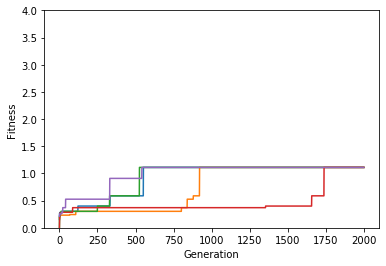

In [20]:
fitness_hist = []
for i in range(5):
    bestRoute, fitness = geneticAlgorithm(
                    population=movements, 
                    popSize=50,
                    eliteSize=4, 
                    mutationRate=0.25, 
                    generations=2000)
    fitness_hist.append(fitness)
    print('Run ' + str(i) + ' got us a fitness of ' + str(fitness_hist[-1]) + ' for the route:')
    pprint(bestRoute)
    print('')
    
print('Average fitness: ' + str(np.mean(fitness_hist)))

## But are GAs more than just random search?

We run the genetic algorithm with a mutation rate of 100%. In principle this is very close to performing a random search for the optimal solution. How does this compare to the GA above? Which method converges faster?

**Beware** this might take some time to execute to the constant random generation of solutions

Run 0 got us a fitness of 0.15384615384615385 for the route:
[<Οps.EAST: 2>, <Οps.WEST: 4>]

Run 1 got us a fitness of 0.17543859649122806 for the route:
[<Οps.EAST: 2>, <Οps.WEST: 4>, <Οps.EAST: 2>]

Run 2 got us a fitness of 0 for the route:
[<Οps.SOUTH: 3>,
 <Οps.WEST: 4>,
 <Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.WEST: 4>,
 <Οps.WEST: 4>,
 <Οps.NORTH: 1>,
 <Οps.WEST: 4>,
 <Οps.WEST: 4>,
 <Οps.WEST: 4>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.WEST: 4>,
 <Οps.EAST: 2>,
 <Οps.NORTH: 1>,
 <Οps.NORTH: 1>,
 <Οps.WEST: 4>,
 <Οps.NORTH: 1>,
 <Οps.WEST: 4>,
 <Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.WEST: 4>,
 <Οps.SOUTH: 3>,
 <Οps.SOUTH: 3>,
 <Οps.NORTH: 1>,
 <Οps.EAST: 2>,
 <Οps.WEST: 4>]

Run 3 got us a fitness of 0 for the route:
[<Οps.SOUTH: 3>,
 <Οps.EAST: 2>,
 <Οps.SOUTH: 3>,
 <Οps.NORTH: 1>,
 <Οps.NORTH: 1>,
 <Οps.WEST: 4>,
 <Οps.EAST: 2>,
 <Οps.EAST: 2>,
 <Ο

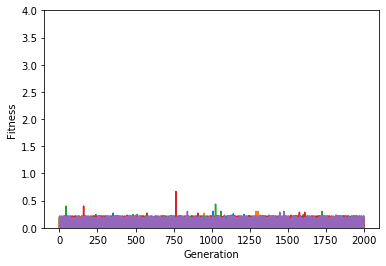

In [21]:
def mutate(individual, mutationRate):
    """
    :brief: Generating a completely new and random solutions 

    :param individual: list of Ops enums
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :return: list of Ops enums (either the mutated individual or the original)
    """
    for i in range(len(individual)):
        if (random.random() < mutationRate):
            individual = createRoute(movements)      
    return individual


def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    :brief: The GA generation step. It will serially perform selection, crossover and mutation 

    :param currentGen: list of lists of Ops enums (the population as defined in the previous generation)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :return: list of lists of Ops enums (the population after selecting, crossing and mutating)
    """
    nextGeneration = mutatePopulation(currentGen, mutationRate, eliteSize)
    return nextGeneration


def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    """
    :brief: The GA main loop that will iterate until the selected number of generation has been reached

    :param population: list Ops enums (the initial movement primitives that are available)
    :param popSize: int (the number of individuals to evolve)
    :param eliteSize: int (the number of elite individuals that should be preserved)
    :param mutationRate: float (probability that one individual will be selected for mutation)
    :param generations: int (the number of generations to run)
    :return: tuple of list Ops enums and float  (the best series of moves and corresponding fitness found by the GA)
    """
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(rankRoutes(pop)[0][1])

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
        
    plt.plot(progress)
    plt.ylabel('Fitness')
    plt.xlabel('Generation')
    ax = plt.gca()
    ax.set_ylim([0, 4])
    
    return (bestRoute, rankRoutes(pop)[0][1])

fitness_hist = []
for i in range(5):
    bestRoute, fitness = geneticAlgorithm(
                    population=movements, 
                    popSize=50,
                    eliteSize=1, 
                    mutationRate=1.0, # we choose to mutate every individual of the population (except the elite)
                    generations=2000)
    fitness_hist.append(fitness)
    print('Run ' + str(i) + ' got us a fitness of ' + str(fitness_hist[-1]) + ' for the route:')
    pprint(bestRoute)
    print('')
    
print('Average fitness: ' + str(np.mean(fitness_hist)))